<a href="https://colab.research.google.com/github/shivani1912/Priccing-Analytics/blob/master/Pricing_for_Revenue_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective: Determine the optimal discount to be given to each client to maximize the revenue

# Loading & Preparing the Dataset


In [ ]:
import scipy
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/ormarketing/b2b/master/data.csv') 

In [ ]:
df.columns

Index(['ID', 'Close Date', 'Created Date', 'New Logo', 'Type', 'Stage',
       'Billing Plan', ' ACV ', ' Discount Amount ', ' Amount ',
       ' Net Amount '],
      dtype='object')

In [ ]:
#renaming created date & closed date columns for easier data wrangling
df.rename(columns={'Created Date': 'Created_Date', 'Close Date': 'Close_Date'}, inplace=True)


In [ ]:
#splitting the date in month, day of the month for capturing seasonality trends
df[['Month','Day_of_Month','Year']] = df.Created_Date.str.split("/",expand=True) 
df['Month'] = np.array(df['Month'], dtype=np.int_)
df['Day_of_Month'] = np.array(df['Day_of_Month'], dtype=np.int_)

In [ ]:
#create binary variables for different Sales Channels
df['Partner cloud']=np.where(df['Type'] =='Partner - Cloud Product', 1.0,0.0)
df['Partner prem']=np.where(df['Type'] =='Partner - OnPremise Product', 1.0, 0.0)
df['Direct cloud']=np.where(df['Type'] =='Direct - Cloud Product', 1.0,0.0)
df['Direct prem']=np.where(df['Type'] =='Direct - OnPremise Product', 1.0, 0.0)
#making sure entries are numeric.
df['amount']=pd.to_numeric(df[' Amount '],errors='coerce')
df['net amount']=pd.to_numeric(df[' Net Amount '],errors='coerce')
#getting discount & depth of discount
df['discount']=df['amount']-df['net amount']
df['depth']=df['discount']/df['amount']



In [ ]:
#classifying as Won & Lost
df['Stage']=np.where(df['Stage'] =='Closed Lost', 'Lost', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Won - Paid', 'Won', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Won - Not Paid', 'Won', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed - Lost', 'Lost', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Lost - Not Renewing', 'Lost', df['Stage'])
df['y']=np.where(df['Stage'] =='Won', 1.0,0.0)

#getting end of quarter for each record
quarter_end=[]
for my_date in df['Created_Date']:
  newrow=pd.to_datetime(my_date) + pd.offsets.QuarterEnd()
  quarter_end.append(newrow)
df['quarter_end']=quarter_end

#getting the number of Days from end of quarter
df['Days_from_Quarter_End']=(df['quarter_end']-pd.to_datetime(df['Created_Date'])).dt.days

In [ ]:
data=df

In [ ]:

np.array(df['Days_from_Quarter_End'], dtype=np.int)

array([57, 32, 22, ...,  9, 37, 79])

In [ ]:
#Dealing with negative discounts
data[data['discount']<0] #Number of negative discounts


,ID,Close_Date,Created_Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount,Month,Day_of_Month,Year,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth,y,quarter_end,Days_from_Quarter_End
928,929,11/14/16,4/26/16,0,Direct - OnPremise Product,Lost,NaN,74400,-14400,60000,74400,4,26,16,0.0,0.0,0.0,1.0,60000.0,74400.0,-14400.0,-0.24,0.0,2016-06-30,65


There is one record of negative discount. We will make this discount positive as this seems to be a human error.

In [ ]:
data['discount']=data['discount'].abs()

In [ ]:
data[pd.isnull(data['Billing Plan'])]


,ID,Close_Date,Created_Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount,Month,Day_of_Month,Year,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth,y,quarter_end,Days_from_Quarter_End
17,18,12/7/16,12/7/16,0,Direct - OnPremise Product,Lost,NaN,32000,NaN,32000,32000,12,7,16,0.0,0.0,0.0,1.0,32000.0,32000.0,0.0,0.0,0.0,2016-12-31,24
24,25,1/4/17,12/28/16,0,Partner - Cloud Product,Lost,NaN,NaN,NaN,32000,32000,12,28,16,1.0,0.0,0.0,0.0,32000.0,32000.0,0.0,0.0,0.0,2016-12-31,3
32,33,5/31/16,1/4/16,0,Partner - OnPremise Product,Lost,NaN,22000,NaN,22000,22000,1,4,16,0.0,1.0,0.0,0.0,22000.0,22000.0,0.0,0.0,0.0,2016-03-31,87
35,36,5/19/16,2/19/16,0,Partner - OnPremise Product,Lost,NaN,125000,NaN,125000,125000,2,19,16,0.0,1.0,0.0,0.0,125000.0,125000.0,0.0,0.0,0.0,2016-03-31,41
39,40,11/4/16,5/23/16,0,Partner - Cloud Product,Lost,NaN,NaN,NaN,500000,500000,5,23,16,1.0,0.0,0.0,0.0,500000.0,500000.0,0.0,0.0,0.0,2016-06-30,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,1499,7/25/17,5/22/17,1,Partner - OnPremise Product,Lost,NaN,32000,NaN,32000,32000,5,22,17,0.0,1.0,0.0,0.0,32000.0,32000.0,0.0,0.0,0.0,2017-06-30,39
1499,1500,7/20/17,5/25/17,1,Partner - OnPremise Product,Lost,NaN,32000,NaN,32000,32000,5,25,17,0.0,1.0,0.0,0.0,32000.0,32000.0,0.0,0.0,0.0,2017-06-30,36
1500,1501,2/4/16,9/17/15,0,Direct - OnPremise Product,Lost,NaN,17900,NaN,17900,17900,9,17,15,0.0,0.0,0.0,1.0,17900.0,17900.0,0.0,0.0,0.0,2015-09-30,13
1501,1502,10/4/16,2/5/16,0,Partner - OnPremise Product,Lost,NaN,60000,NaN,60000,60000,2,5,16,0.0,1.0,0.0,0.0,60000.0,60000.0,0.0,0.0,0.0,2016-03-31,55


In [ ]:
data['Billing Plan'].unique()

array(['3 Years', '4 Years', '2 Years', nan, 'Annual', '5 Years',
       '3 Months', '9 Months', 'Quarterly'], dtype=object)

Billing plan cannot be an explanatory variable since that is determined after winning the deal not when the lead is created.

# Splitting the data into estimation & holdout samples

In [ ]:
#splitting the data set for estimation & hold out
estimation_df=data[data['ID']<1201]
holdout_df=data[data['ID']>=1201]

In [ ]:
estimation_df.columns

Index(['ID', 'Close_Date', 'Created_Date', 'New Logo', 'Type', 'Stage',
       'Billing Plan', ' ACV ', ' Discount Amount ', ' Amount ',
       ' Net Amount ', 'Month', 'Day_of_Month', 'Year', 'Partner cloud',
       'Partner prem', 'Direct cloud', 'Direct prem', 'amount', 'net amount',
       'discount', 'depth', 'y', 'quarter_end', 'Days_from_Quarter_End'],
      dtype='object')

In [ ]:
estimation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     1200 non-null   int64         
 1   Close_Date             1200 non-null   object        
 2   Created_Date           1200 non-null   object        
 3   New Logo               1200 non-null   int64         
 4   Type                   1200 non-null   object        
 5   Stage                  1200 non-null   object        
 6   Billing Plan           826 non-null    object        
 7    ACV                   1171 non-null   object        
 8    Discount Amount       538 non-null    object        
 9    Amount                1200 non-null   object        
 10   Net Amount            1200 non-null   object        
 11  Month                  1200 non-null   int64         
 12  Day_of_Month           1200 non-null   int64         
 13  Yea

# Exploratory Data Analysis


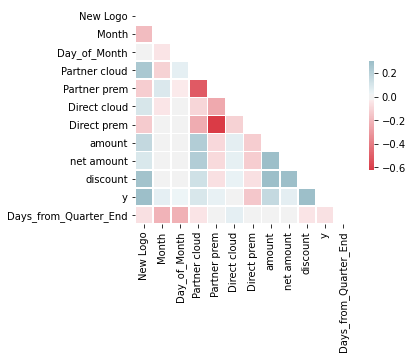

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
corr = estimation_df[[ 'New Logo', 'Stage',
         ' Discount Amount ', ' Amount ',
       ' Net Amount ', 'Month', 'Day_of_Month', 'Partner cloud',
       'Partner prem', 'Direct cloud', 'Direct prem', 'amount', 'net amount',
       'discount', 'y', 'Days_from_Quarter_End']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the matrix, we notice that for Y there is some degree of
* positive correlation with New Logo,Amount & Discount
* negative correlation with Days_from_Quarter_End




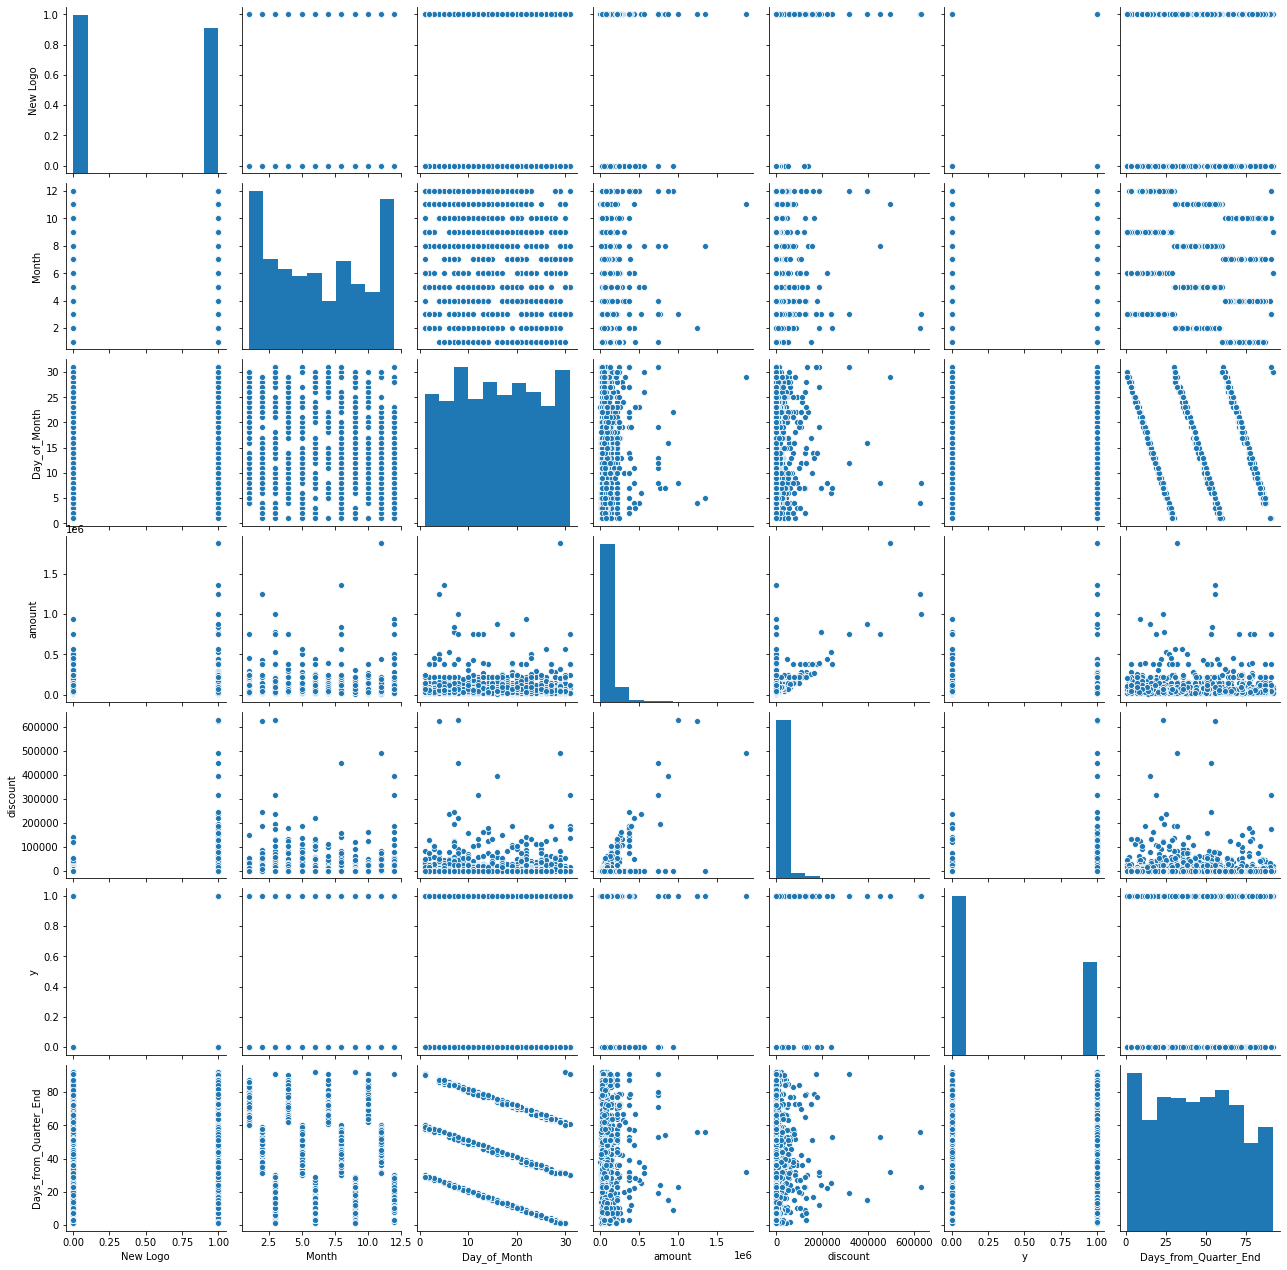

In [ ]:

sns.pairplot(estimation_df[[ 'New Logo', 'Stage','Type',
         ' Discount Amount ', ' Amount ',
       ' Net Amount ', 'Month', 'Day_of_Month', 'amount',
       'discount', 'y', 'Days_from_Quarter_End']])

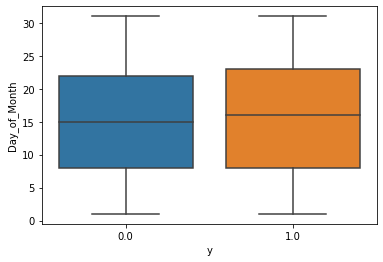

In [ ]:
ax = sns.boxplot(x="y", y="Day_of_Month", data=estimation_df)

No difference in Win & Lost pertaining to Day of Month

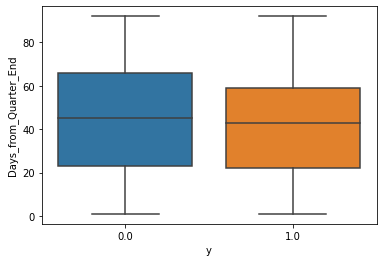

In [ ]:
ax = sns.boxplot(x="y", y="Days_from_Quarter_End", data=estimation_df)

Some difference in Win & Lost Deals in terms of Days from Quarter End

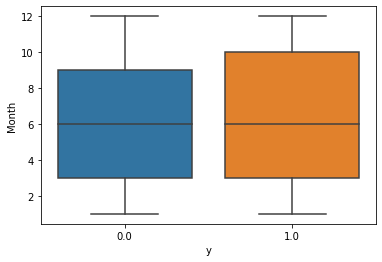

In [ ]:
ax = sns.boxplot(x="y", y="Month", data=estimation_df)

No difference in Win & Lost pertaining to Month

# Building the logit models for predicting probability of winning the deal for the 4 Types

\begin{equation}
p(Y=1|x)=\frac{e^{x'\beta}}{1+e^{x'\beta}}
\end{equation}

In our case 
\begin{equation}
x'\beta=\beta_0+\beta_1\times \text{Amount}+\beta_2 \times \text{Discount}+\beta_3 \times \text{New Logo}+\beta_4 \times \text{Discount}+\beta_5 \times \text{Days_from_Quarter_End}
\end{equation}


source: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.cdf.html#statsmodels.discrete.discrete_model.Logit.cdf


In [ ]:

#Price Response function
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

#Normalizing the training set 
channels= {}
for channel in (estimation_df['Type'].unique()):
  regressiondata=estimation_df[estimation_df['Type']==channel][['y','discount','amount','New Logo','Days_from_Quarter_End']]
  y=regressiondata['y']
  x=regressiondata[['discount','amount','New Logo','Days_from_Quarter_End']]
  model = sm.Logit(y, x, missing='drop')
  model.fit
  type(model)
  result=model.fit()
  channels[channel]= result.params
  print("Logistic Results for "+channel)
  print(result.summary())
   
    


Optimization terminated successfully.
         Current function value: 0.399474
         Iterations 8
Logistic Results for Direct - Cloud Product
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       46
Method:                           MLE   Df Model:                            3
Date:                Mon, 08 Jun 2020   Pseudo R-squ.:                  0.3984
Time:                        07:16:15   Log-Likelihood:                -19.974
converged:                       True   LL-Null:                       -33.203
Covariance Type:            nonrobust   LLR p-value:                 7.643e-06
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
discount               6.074e-05   2.37e-0

At p=0.05 significance, 

We observe that for all channels except Partner - Cloud Product the significant explanatory variables are:
* Discount
* Amount
* New Logo
* Days_from_Quarter_End

For Partner - Cloud Product the significant explanatory variables are:
* Discount
* Amount
* New Logo


In [ ]:
#saved parameter estimates for each channel in the channels dictionary
channels

{'Direct - Cloud Product': discount                 0.000061
 amount                  -0.000024
 New Logo                 2.447230
 Days_from_Quarter_End   -0.033786
 dtype: float64,
 'Direct - OnPremise Product': discount                 0.000065
 amount                  -0.000015
 New Logo                 1.266668
 Days_from_Quarter_End   -0.025373
 dtype: float64,
 'Partner - Cloud Product': discount                 0.000054
 amount                  -0.000014
 New Logo                 1.213996
 Days_from_Quarter_End   -0.008059
 dtype: float64,
 'Partner - OnPremise Product': discount                 0.000103
 amount                  -0.000004
 New Logo                 1.216281
 Days_from_Quarter_End   -0.025989
 dtype: float64}

In [ ]:
#updating the paramaters based on the significance of each of the 4 logit models
 
def update_PartnerCloud(result_parameters):
   result_parameters[3]=0
   return result_parameters
 


# Finding the discount to be given to each client to optimize the revenue based on the probability of winning from our model

\begin{equation}
R(p)=Proba(Y=1|p,d) \times (p-d)
\end{equation}



In [ ]:

#Attempt to personalized pricing


h_df=holdout_df[['discount','amount','New Logo','Days_from_Quarter_End','Type','ID']]

ID=1201
ID_max=1506
opt_dis_df=pd.DataFrame(columns=["ID","optimal_discount"]) 
while ID<=ID_max-1:
  client_df=h_df.iloc[ID-1201,0:6] #index is one less than the ID 
  client_channel=client_df['Type']
  result_parameters=channels.get(client_channel) #getting the parameters based on the Type of sales channel of the client
 #update the coefficients based on the different models
  if(client_channel=='Partner - Cloud Product'):
    result_parameters=update_PartnerCloud(result_parameters)

  UT=np.matmul(client_df[1:4],result_parameters[1:4])
  #print(UT)
  b=result_parameters[0]
  p=client_df[1]
  def revenueD(d):
    """This is the negative revenue function"""
    return -np.exp(UT+b*np.sqrt(d**2))/(1+np.exp(UT+b*np.sqrt(d**2)))*(p-np.sqrt(d**2))
  sol3=minimize_scalar(revenueD,bounds=(0, 0))
  new_row=pd.DataFrame([[client_df['ID'],sol3.x]], columns=["ID","optimal_discount"])     
  opt_dis_df=opt_dis_df.append(new_row)
  ID=ID+1
 

In [ ]:
opt_dis_df['optimal_discount']=np.sqrt(opt_dis_df['optimal_discount']**2)

In [ ]:
holdout_opt_dis=pd.merge(holdout_df,opt_dis_df, on='ID',how='inner')

In [ ]:
print(round(np.mean(holdout_opt_dis['optimal_discount']),0),np.round(np.mean(holdout_opt_dis['discount']),0))

15074.0 12685.0


# **Computation Revenue Improvement**


##a. Expected revenue improvement over un-optimized discounts (take the actual discounts in the data-set) for leads in the hold-out sample


In [ ]:
#Using our probability models

h_df=holdout_opt_dis[['discount','amount','New Logo','Days_from_Quarter_End','Type','ID']]

ID=1201
ID_max=1506
unopt_rev_df=pd.DataFrame(columns=["ID","unoptimized_rev","probability"]) 
while ID<=ID_max-1:
  client_df=h_df.iloc[ID-1201,0:6] #index is one less than the ID 
  client_channel=client_df['Type']
  result_parameters=channels.get(client_channel) #getting the parameters based on the Type of sales channel of the client
 #update the coefficients based on the different models
  if(client_channel=='Partner - Cloud Product'):
    result_parameters=update_PartnerCloud(result_parameters)
  UT=np.matmul(client_df[0:4],result_parameters[0:4])
  #print(UT)
  b=result_parameters[0]
  p=client_df[1]
  d=client_df[0]
  prob=np.exp(UT)/(1+np.exp(UT))
  unoptimized_rev=prob*(client_df[1]-client_df[0])
  new_row=pd.DataFrame([[client_df['ID'],unoptimized_rev,prob]], columns=["ID","unoptimized_rev","probability"])     
  unopt_rev_df=unopt_rev_df.append(new_row)
  ID=ID+1
 

In [ ]:

holdout_unoptimized=pd.merge(holdout_df,unopt_rev_df,on='ID', how='inner')
holdout_unoptimized['Revenue']=np.where(holdout_unoptimized['Stage'] =='Won',holdout_unoptimized['net amount'] ,0.0)
holdout_unoptimized['unoptimized_rev']=np.where(holdout_unoptimized['probability'] > 0.5,holdout_unoptimized['unoptimized_rev'] ,0.0)
round(np.sum(holdout_unoptimized['unoptimized_rev'])/np.sum(holdout_unoptimized['Revenue']),2)

1.04

4% increase in revenue based on our probability model. This  is a good indicator that our models are performing well as the increment should be really low and close to the old revenue.

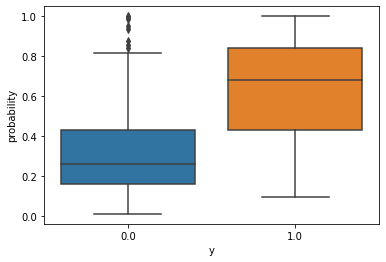

In [ ]:
ax = sns.boxplot(x="y", y="probability", data=holdout_unoptimized)

Based on the boxplot (where blue indicates lost deals & orange indicates won deals), our model is able to accurately predict the probability of winning for Won & Lost deals


## b. Expected revenue improvement over optimized discounts (based on your estimation results, optimize discounts offered to leads in the hold-out sample).

In [ ]:
#Attempt to personalized pricing

h_df=holdout_opt_dis[['optimal_discount','amount','New Logo','Days_from_Quarter_End','Type','ID']]

ID=1201
ID_max=1506
opt_rev_df=pd.DataFrame(columns=["ID","optimized_rev","probability"]) 
while ID<=ID_max-1:
  client_df=h_df.iloc[ID-1201,0:6] #index is one less than the ID 
  client_channel=client_df['Type']
  result_parameters=channels.get(client_channel) #getting the parameters based on the Type of sales channel of the client
  #update the coefficients based on the different models
  if(client_channel=='Partner - Cloud Product'):
    result_parameters=update_PartnerCloud(result_parameters)
  UT=np.dot(client_df[0:4],result_parameters[0:4])
  #print(UT)
  b=result_parameters[0]
  p=client_df[1]
  d=client_df[0]
  prob=np.exp(UT)/(1+np.exp(UT))
  optimized_rev=prob*(client_df[1]-client_df[0])
  new_row=pd.DataFrame([[client_df['ID'],optimized_rev,prob]], columns=["ID","optimized_rev","probability"])     
  opt_rev_df=opt_rev_df.append(new_row)
  ID=ID+1
 

In [ ]:
holdout_optimized=pd.merge(holdout_opt_dis,opt_rev_df,on='ID', how='inner')
holdout_optimized['Revenue']=np.where(holdout_optimized['Stage'] =='Won',holdout_optimized['net amount'] ,0.0)
holdout_optimized['optimized_rev']=np.where(holdout_optimized['probability'] > 0.5,holdout_optimized['optimized_rev'] ,0.0)
round(np.sum(holdout_optimized['optimized_rev'])/np.sum(holdout_optimized['Revenue']),2)

1.63

We take the threshold of probability of winning to be 0.5. Anything greater than that is considered to be a winning deal. Based on that the increase in revenue for optimized discount is 63% .



#Revenue Optimization for each sales channel




In [ ]:
holdout_optimized.columns

Index(['ID', 'Close_Date', 'Created_Date', 'New Logo', 'Type', 'Stage',
       'Billing Plan', ' ACV ', ' Discount Amount ', ' Amount ',
       ' Net Amount ', 'Month', 'Day_of_Month', 'Year', 'Partner cloud',
       'Partner prem', 'Direct cloud', 'Direct prem', 'amount', 'net amount',
       'discount', 'depth', 'y', 'quarter_end', 'Days_from_Quarter_End',
       'optimal_discount', 'optimized_rev', 'probability', 'Revenue'],
      dtype='object')

In [ ]:
dff=holdout_optimized[['Type','Stage','discount','optimal_discount','Revenue','optimized_rev']]
round(dff.groupby('Type').mean(),2)

,discount,optimal_discount,Revenue,optimized_rev
Type,,,,
Direct - Cloud Product,12471.76,23878.24,9029.41,25374.96
Direct - OnPremise Product,2937.01,8868.15,4851.02,6554.16
Partner - Cloud Product,52629.22,37672.75,58460.92,84156.38
Partner - OnPremise Product,10492.98,13317.13,15357.20,27541.48


In [ ]:
model_sum=round(dff.groupby('Type').mean(),2)

In [ ]:
model_sum['optimal_discount']-model_sum['discount']

Type
Direct - Cloud Product         11406.48
Direct - OnPremise Product      5931.14
Partner - Cloud Product       -14956.47
Partner - OnPremise Product     2824.15
dtype: float64

With the new strategy, we need to increase the mean discount offered for all the types (Sales Channels and products) except for Partner Cloud Product. For Partner Cloud Product it seems that we need to decrease the discount from the current values.


